In [1]:
import cv2
import numpy as np
import pandas as pd

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.losses import binary_crossentropy
import keras.backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from os import listdir
ids_list = [x.split('.')[0] for x in listdir('data/train')]

In [4]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + (1 - dice_loss(y_true, y_pred))

def unet_down_one_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet_max_pool(inputs):
    x = MaxPooling2D((2, 2), strides=(2, 2))(inputs)
    return x

def unet_up_one_block(up_input, down_input, num_filters):
    x = UpSampling2D((2,2))(up_input)
    x = concatenate([down_input, x], axis=3)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def get_unet(input_shape = (256, 256, 3),
             num_classes = 1,
             initial_filters = 32,
             central_filters = 1024):
    
    num_filters = initial_filters
    
    out_list    = [Input(shape=input_shape)]
    down_interim_list = []
    
    while num_filters <= central_filters/2:
        x = unet_down_one_block(out_list[-1], num_filters)
        down_interim_list.append(x)
        num_filters = num_filters * 2
        y = unet_max_pool(x)
        out_list.append(y)
    
    x = unet_down_one_block(out_list[-1], num_filters)
    out_list.append(x)
    num_filters = int(num_filters / 2)
    
    while num_filters >= initial_filters:
        x = unet_up_one_block(out_list[-1], down_interim_list.pop(), num_filters)
        out_list.append(x)
        num_filters = int(num_filters / 2)
    
    classify = Conv2D(num_classes, (1,1), activation = 'sigmoid')(out_list[-1])
    
    model = Model(inputs=out_list[0], outputs=classify)
    
    model.compile(optimizer=RMSprop(lr=0.0001),
                  loss=bce_dice_loss,
                  metrics=[dice_loss])
    
    return model

In [5]:
orig_width = 1918
orig_height= 1280

def dice_loss_numpy(y_true, y_pred):
    return 2*np.sum(np.multiply(y_true, y_pred))/(np.sum(y_pred) + np.sum(y_true))

# 512 model

In [6]:
model = get_unet(input_shape=(512,512,3), initial_filters=16)
model.load_weights(filepath='weights/best_weights_512_2.hdf5')

In [7]:
input_size=512

In [8]:
all_imgs=[]
for id in ids_list:
    img = cv2.imread('data/train/{}.jpg'.format(id))
    img = cv2.resize(img, (input_size, input_size))
    all_imgs.append(img)

In [9]:
preds = model.predict(np.array(all_imgs, np.float32)/255, batch_size=16)
preds = np.squeeze(preds, axis=3)

In [10]:
dice_loss_512=[]
for i in range(len(ids_list)):
    tmp = np.copy(preds[i,:,:])
    tmp = cv2.resize(tmp, (orig_width, orig_height))
    tmp = (tmp > 0.5).astype(int)
    mask = cv2.imread('data/train_masks/{}_mask.png'.format(ids_list[i]), cv2.IMREAD_GRAYSCALE)/255
    dice_loss_512.append(dice_loss_numpy(mask, tmp))

In [19]:
import pickle
pickle.dump( dice_loss_512, open( "dice_loss_512.pkl", "wb" ) )

# 1024 model

In [6]:
model = get_unet(input_shape=(1024,1024,3), initial_filters=8)
model.load_weights(filepath='weights/best_weights_1024_2.hdf5')

In [7]:
input_size=1024

In [8]:
val_batch_size   = 16

In [14]:
from tqdm import tqdm

In [15]:
dice_loss_1024=[]
for start in tqdm(range(0, len(ids_list), val_batch_size)):
    x_batch = []
    end = min(start + val_batch_size, len(ids_list))
    ids_test_batch = ids_list[start:end]
    for id in ids_test_batch:
        img = cv2.imread('data/train/{}.jpg'.format(id))
        img = cv2.resize(img, (input_size, input_size))
        x_batch.append(img)
    x_batch = np.array(x_batch, np.float32) / 255
    preds = model.predict_on_batch(x_batch)
    preds = np.squeeze(preds, axis=3)
    
    for i in range(len(ids_test_batch)):
        tmp = np.copy(preds[i,:,:])
        tmp = cv2.resize(tmp, (orig_width, orig_height))
        tmp = (tmp > 0.5).astype(int)
        mask = cv2.imread('data/train_masks/{}_mask.png'.format(ids_test_batch[i]), cv2.IMREAD_GRAYSCALE)/255
        dice_loss_1024.append(dice_loss_numpy(mask, tmp))


100%|██████████| 318/318 [18:15<00:00,  3.43s/it]


In [18]:
import pickle
pickle.dump( dice_loss_1024, open( "dice_loss_1024.pkl", "wb" ) )

# Full res model

In [6]:
model = get_unet(input_shape=(1024,1024,3), initial_filters=8)
model.load_weights(filepath='weights/best_weights_fullres3.hdf5')

In [7]:
val_batch_size = 8
threshold = 0.5

In [8]:
import pickle
test_bboxes = pickle.load( open( "./train_bboxes.pkl", "rb" ) )

In [9]:
from tqdm import tqdm

In [10]:
dice_loss_fullres=[]
for start in tqdm(range(0, len(ids_list), val_batch_size)):
    
    x_batch = []
    end = min(start + val_batch_size, len(ids_list))
    ids_test_batch = ids_list[start:end]
    
    for id in ids_test_batch:
        img = cv2.imread('data/train/{}.jpg'.format(id))
        
        this_bbox = test_bboxes[id]
        img_1_box = this_bbox[0]
        img_2_box = this_bbox[1]
        
        img_1 = np.copy(img[img_1_box[2]:(img_1_box[3]+1), img_1_box[0]:(img_1_box[1]+1),:])
        img_2 = np.copy(img[img_2_box[2]:(img_2_box[3]+1), img_2_box[0]:(img_2_box[1]+1),:])
        img_2 = cv2.flip(img_2, 1)
        
        x_batch.append(img_1)
        x_batch.append(img_2)
    
    x_batch = np.array(x_batch, np.float32) / 255
    preds = model.predict_on_batch(x_batch)
    preds = np.squeeze(preds, axis=3)
    
    final_preds = []
    for i in range(len(ids_test_batch)):
        id = ids_test_batch[i]
        
        this_bbox = test_bboxes[id]
        img_1_box = this_bbox[0]
        img_2_box = this_bbox[1]
        
        pred_1 = np.copy(preds[(i*2), :, :])
        pred_2 = np.copy(preds[(i*2) + 1, :, :])
        pred_2 = cv2.flip(pred_2, 1)
        
        left_part   = np.copy(pred_1[:, 0:894])
        middle_1    = np.copy(pred_1[:, 894:1024])
        middle_2    = np.copy(pred_2[:, 0:130])
        middle_part = np.add(middle_1, middle_2)/2
        right_part  = np.copy(pred_2[:, 130:1024])
        all_parts   = np.concatenate((left_part, middle_part, right_part), axis=1)
        
        if img_1_box[2] != 0:
            top_part = np.zeros(shape = (img_1_box[2],1918), dtype = np.float32)
            all_parts = np.concatenate((top_part, all_parts), axis = 0)
            
        if img_1_box[3] != 1279:
            bottom_part = np.zeros(shape = (1279-img_1_box[3],1918), dtype = np.float32)
            all_parts = np.concatenate((all_parts, bottom_part), axis = 0)
        
        final_preds.append(all_parts)
        
    
    for i in range(len(ids_test_batch)):
        tmp = final_preds[i]
        tmp = (tmp > 0.5).astype(int)
        mask = cv2.imread('data/train_masks/{}_mask.png'.format(ids_test_batch[i]), cv2.IMREAD_GRAYSCALE)/255
        dice_loss_fullres.append(dice_loss_numpy(mask, tmp))

100%|██████████| 636/636 [32:03<00:00,  3.02s/it]


In [11]:
import pickle
pickle.dump( dice_loss_fullres, open( "dice_loss_fullres.pkl", "wb" ) )

# Comparison

In [6]:
import pickle

In [7]:
df = pd.DataFrame({'id'    : ids_list,
                   'm512'  : pickle.load( open( "./dice_loss_512.pkl", "rb" ) ),
                   'm1024' : pickle.load( open( "./dice_loss_1024.pkl", "rb" ) ),
                   'mfull' : pickle.load( open( "./dice_loss_fullres.pkl", "rb" ) )
                  })

In [8]:
df.head()

,id,m1024,m512,mfull
0,fecea3036c59_13,0.997721,0.997493,0.997894
1,a078586ccdee_10,0.997255,0.996585,0.997734
2,a2df64508b97_06,0.996331,0.996635,0.997433
3,4bea0766c14c_10,0.997822,0.997272,0.998054
4,c3614abc7405_09,0.995865,0.996198,0.997340


In [9]:
df.m512.corr(df.m1024)

0.89330155866443206

In [10]:
df.m512.corr(df.mfull)

0.83603164126970209

In [11]:
df.m1024.corr(df.mfull)

0.88858245001854264

In [14]:
((df.m512+df.mfull)/2).corr(df.m1024)

0.92990512956699967

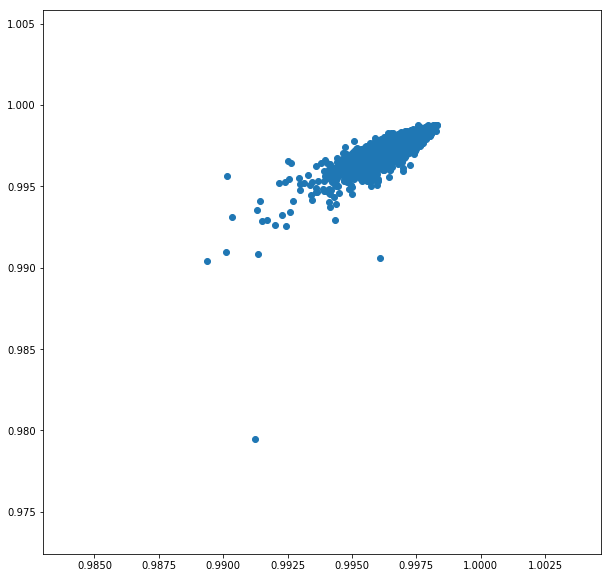

In [15]:
plt.figure(figsize=(10, 10))
plt.scatter(df.m512, df.mfull);

# Worst predictions of each model

ToDo